In [2]:
# Kiểm tra GPU được cấp phát
!nvidia-smi

# Cài đặt các thư viện cần thiết
!pip install torch torchvision
!pip install roboflow
!pip install opencv-python
!pip install matplotlib

# Cài đặt Detectron2
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git'

Fri Feb 28 16:32:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
# Tải dataset từ Roboflow ở định dạng COCO
from roboflow import Roboflow
rf = Roboflow(api_key="bcLcEpxMIQLbehAgWUQa")
project = rf.workspace("roboflow-100").project("x-ray-rheumatology")
version = project.version(2)
dataset = version.download("coco")

# In thông tin về dataset
print(f"Dataset đã được tải về tại: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to x-ray-rheumatology-2 in coco:: 100%|██████████| 193/193 [00:00<00:00, 8617.76it/s]

Dataset đã được tải về tại: /content/x-ray-rheumatology-2


In [2]:
import os
import json
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Đường dẫn tới các file annotation COCO
train_json = os.path.join(dataset.location, "train", "_annotations.coco.json")
val_json = os.path.join(dataset.location, "valid", "_annotations.coco.json")
test_json = os.path.join(dataset.location, "test", "_annotations.coco.json")

# Đường dẫn tới thư mục chứa ảnh
train_imgs = os.path.join(dataset.location, "train")
val_imgs = os.path.join(dataset.location, "valid")
test_imgs = os.path.join(dataset.location, "test")

# Đăng ký dataset với Detectron2
register_coco_instances("xray_train", {}, train_json, train_imgs)
register_coco_instances("xray_val", {}, val_json, val_imgs)
register_coco_instances("xray_test", {}, test_json, test_imgs)

# Lấy thông tin và đặt tên lớp
with open(train_json, 'r') as f:
    coco_data = json.load(f)

# Lấy thông tin categories từ file COCO
categories = coco_data['categories']
class_names = [cat['name'] for cat in sorted(categories, key=lambda x: x['id'])]
print("Các lớp trong dataset:", class_names)

# Thiết lập metadata
metadata = MetadataCatalog.get("xray_train")
metadata.thing_classes = class_names

Các lớp trong dataset: ['x-ray-rheumatology', 'artefact', 'distal phalanges', 'fifth metacarpal bone', 'first metacarpal bone', 'fourth metacarpal bone', 'intermediate phalanges', 'proximal phalanges', 'radius', 'second metacarpal bone', 'soft tissue calcination', 'third metacarpal bone', 'ulna']


WARNING [02/28 16:39:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/28 16:39:36 d2.data.datasets.coco]: Loaded 135 images in COCO format from /content/x-ray-rheumatology-2/train/_annotations.coco.json


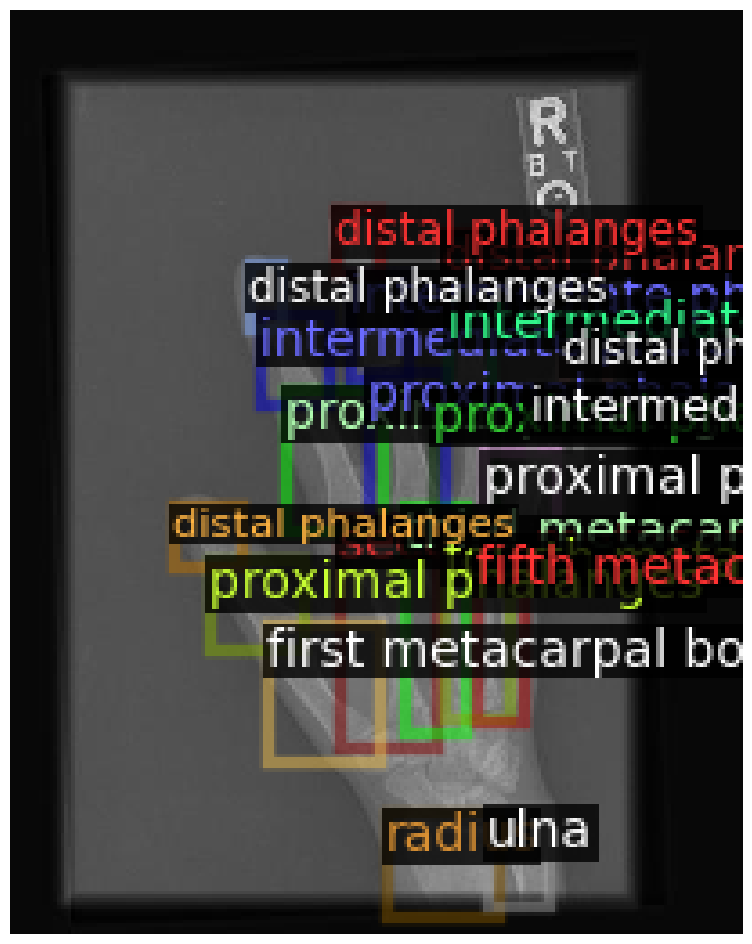

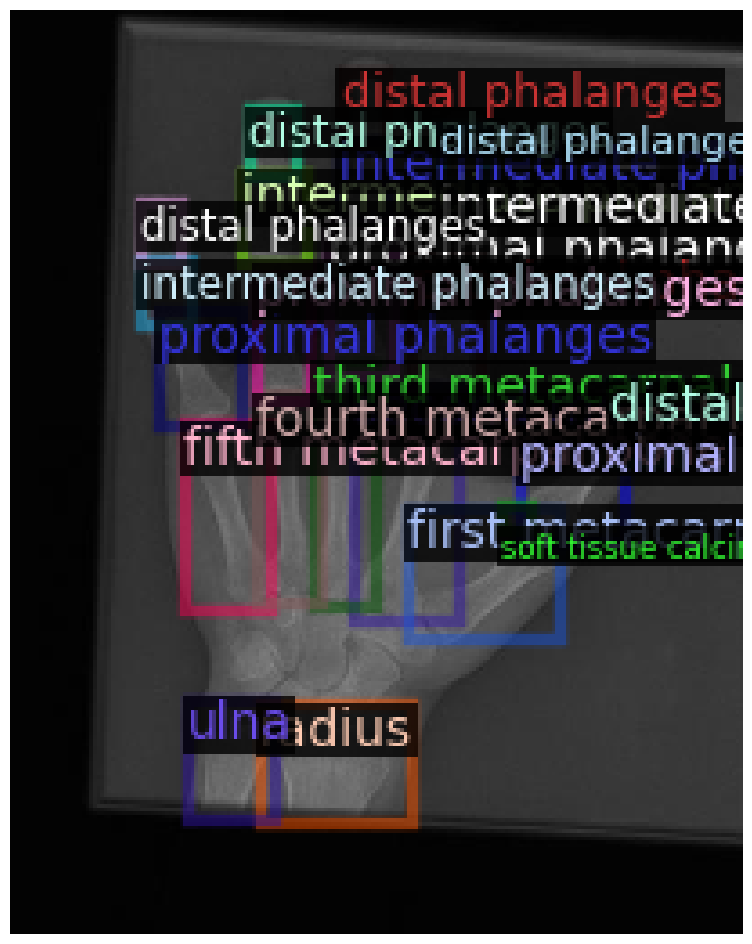

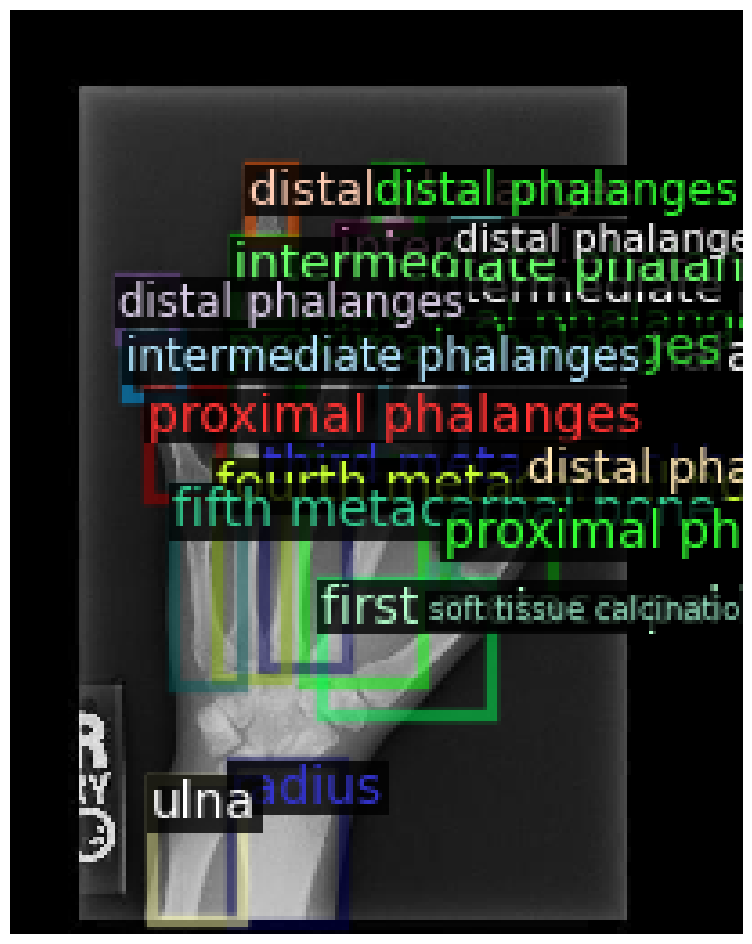

In [3]:
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt
import random

# Lấy một số mẫu từ tập huấn luyện để trực quan hóa
dataset_dicts = DatasetCatalog.get("xray_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(os.path.join(d["file_name"]))
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(12, 12))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

# Tạo lớp Trainer tùy chỉnh với đánh giá trong quá trình huấn luyện
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Thiết lập cấu hình mô hình
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("xray_train",)
cfg.DATASETS.TEST = ("xray_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2  # Điều chỉnh tùy theo RAM của GPU
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000    # Điều chỉnh số vòng lặp tùy thuộc vào kích thước dataset
cfg.SOLVER.STEPS = []
cfg.SOLVER.CHECKPOINT_PERIOD = 500  # Lưu checkpoint mỗi 500 iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_names)  # Số lượng lớp trong dataset
cfg.OUTPUT_DIR = "./output_faster_rcnn_xray"

# Tạo thư mục đầu ra
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Huấn luyện mô hình
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/28 16:39:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 130MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[02/28 16:39:56 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


[02/28 16:40:07 d2.utils.events]:  eta: 0:20:59  iter: 19  total_loss: 5.394  loss_cls: 2.71  loss_box_reg: 0.7583  loss_rpn_cls: 1.703  loss_rpn_loc: 0.2102    time: 0.4216  last_time: 0.4426  data_time: 0.0204  last_data_time: 0.0181   lr: 4.9953e-06  max_mem: 2342M
[02/28 16:40:24 d2.utils.events]:  eta: 0:20:26  iter: 39  total_loss: 4.715  loss_cls: 2.555  loss_box_reg: 0.8249  loss_rpn_cls: 1.133  loss_rpn_loc: 0.228    time: 0.4033  last_time: 0.4387  data_time: 0.0086  last_data_time: 0.0042   lr: 9.9902e-06  max_mem: 2498M
[02/28 16:40:31 d2.utils.events]:  eta: 0:19:31  iter: 59  total_loss: 3.737  loss_cls: 2.335  loss_box_reg: 0.8186  loss_rpn_cls: 0.3182  loss_rpn_loc: 0.1832    time: 0.3892  last_time: 0.3367  data_time: 0.0093  last_data_time: 0.0055   lr: 1.4985e-05  max_mem: 2498M
[02/28 16:40:39 d2.utils.events]:  eta: 0:19:14  iter: 79  total_loss: 3.109  loss_cls: 1.991  loss_box_reg: 0.8745  loss_rpn_cls: 0.09276  loss_rpn_loc: 0.1516    time: 0.3896  last_time: 0.